# Regresión Básica: Predecir eficiencia de gasolina

En un problema de regresión, buscamos predecir la salida de un valor continuo como el de un precio. En contraste en un problema de clasificación, buscamos seleccionar una clase de una lista de clases posibles (por ejemplo, de una imagen que contenga una manzana o una naranja queremos reconocer cual es la fruta en la imagen).

Este ejercicio usa el dataset de datos clásico Auto MPG y se construye un modelo para predecir la eficiencia de consumo de combustible de vehiculos de 1970 y 1980. Para hacer esto, proveeremos al modelo una descripcion de muchos automoviles de ese periodo. Esta descripción incluye atributos como: cilindros, desplazamiento, potencia y peso.

Este ejemplo usa el API `tf.keras` , revise Esta [Guía](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.2


## El set de Datos de MPG
el set de datos esta disponible de el siguiente repositorio UCI Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Auto+MPG

## Obteniendo los datos
Primero descargue el set de datos.

In [16]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\walgom\\.keras\\datasets\\auto-mpg.data'

Impórtelo usando pandas.

In [17]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

# Limpie los datos
El set de datos contiene algunos valores desconocidos o perdidos (missing).

In [18]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Eliminaremos aquellos con valores ausentes.

In [19]:
dataset = dataset.dropna()

In [20]:
dataset

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
0            70       1  
1            70       1  
2            70       1  
3            70       1  
4            70       1  
..          ...     ...  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  

[392 rows x 8 columns]

La columna de `"Origin"` es categorica, no numerica. Entonces debemos convertirla a un formato "one-hot":

In [21]:
origin = dataset.pop('Origin')

In [22]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0

In [23]:
#Si se anima, coloque la implementación con la clase OneHotEncoder e imprima los resultados
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# dataset[['Origin']] = dataset[['Origin']].apply(lambda col: le.fit_transform(col))

# from sklearn.preprocessing import OneHotEncoder
# onehotencoder = OneHotEncoder(sparse = False)
# categoricals_df = pd.DataFrame(onehotencoder.fit_transform(dataset[['Origin']]), columns = le.classes_)
# categoricals_df.head()

# categoricals_df = categoricals_df.set_index(dataset.index)
# dataset = pd.concat([dataset, categoricals_df], axis=1)
# dataset.head()

## Dividamos la data en entrenamiento y prueba
Ahora ser divida el set de datos en un set de entrenamiento y otro de pruebas.
Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

In [24]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [25]:
# Si se anima también, realice la implementación con scikit learn para partir los datos.
X = dataset.drop(['MPG'], axis=1)
y = dataset['MPG']
# Si se anima también, realice la implementación con scikit learn para partir los datos.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Inspeccionando los datos
Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

Inspeccione la data
Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

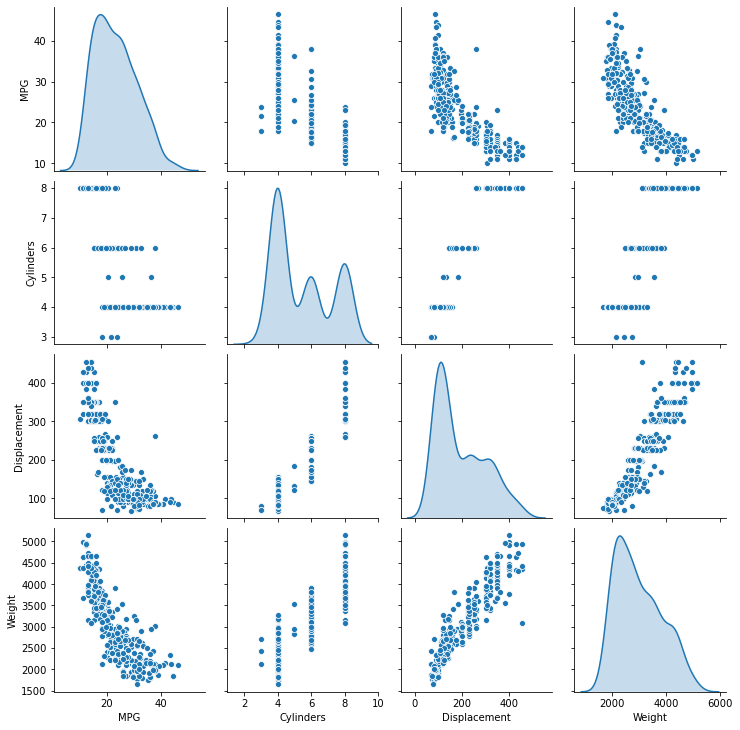

In [26]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

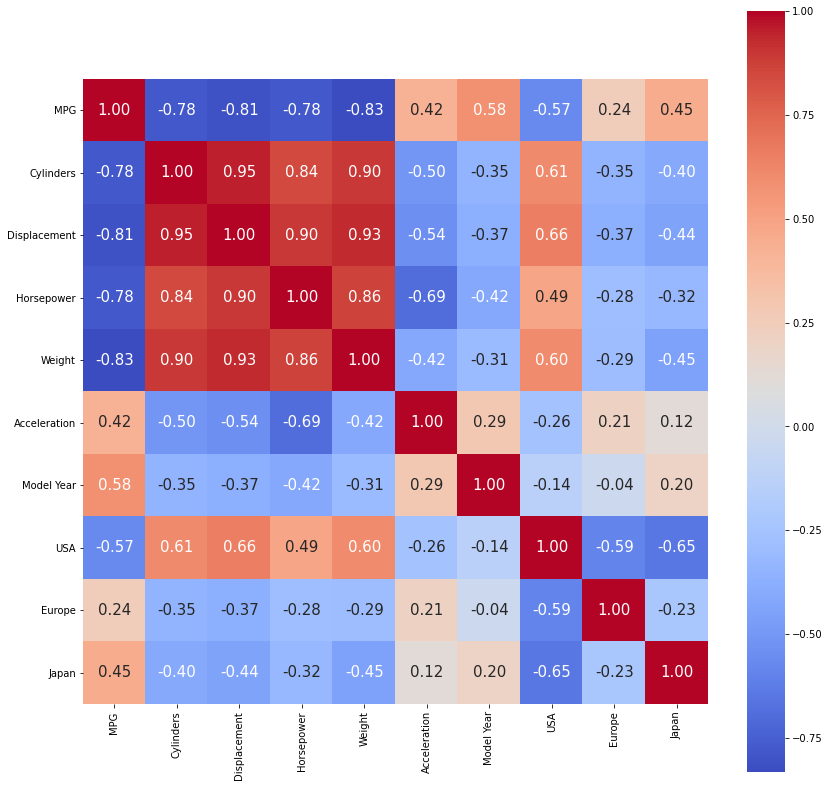

In [27]:
# Como está volando, animese a crear un gráfico de correlación y enuncie de 
# Mayor a menos las variables que tienen correlación con MPG. Omita otras correlaciones por ahora.
corr = dataset.corr(method='pearson') # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= dataset.columns, 
           yticklabels= dataset.columns,
           cmap= 'coolwarm')

plt.show()

# las variables que tienen mas correlacion con mpg son displacement, weight

También revise las estadísticas generales:

In [28]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

In [29]:
# Si es buen googlero, lo invito a que proponga otra libreria para sacar estadísticas rápidamente.
import pandas_profiling
pandas_profiling.ProfileReport(dataset)

C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


## Separe las características de las etiquetas.
Separe el valor objetivo, o la "etiqueta" de las caracteristicas. Esta etiqueta es el valor que usará el modelo como referencia para predecir.

In [30]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## Normalice la data
Revise otra vez el bloque de train_stats que se presento antes y note la diferencia de rangos de cada caracteristica.

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo * podría * converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

Nota: Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [31]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [32]:
train_normed_stats = normed_train_data.describe()
train_normed_stats = train_normed_stats.transpose()
train_normed_stats

count          mean  std       min       25%       50%  \
Cylinders     314.0  1.824443e-16  1.0 -1.457657 -0.869348 -0.869348   
Displacement  314.0  8.627211e-17  1.0 -1.220325 -0.860894 -0.424785   
Horsepower    314.0 -9.900078e-18  1.0 -1.545283 -0.751241 -0.272190   
Weight        314.0 -8.485781e-17  1.0 -1.589352 -0.869478 -0.198782   
Acceleration  314.0 -5.148041e-16  1.0 -2.710152 -0.630725 -0.021237   
Model Year    314.0  9.772791e-16  1.0 -1.604642 -0.788458  0.027726   
USA           314.0  7.920062e-17  1.0 -1.286751 -1.286751  0.774676   
Europe        314.0  1.980016e-17  1.0 -0.465148 -0.465148 -0.465148   
Japan         314.0  5.374328e-17  1.0 -0.495225 -0.495225 -0.495225   

                   75%       max  
Cylinders     1.483887  1.483887  
Displacement  0.675074  2.489002  
Horsepower    0.607162  3.153347  
Weight        0.732017  2.547401  
Acceleration  0.588250  3.313017  
Model Year    0.843910  1.660094  
USA           0.774676  0.774676  
Europe       -0.465148  2.143005  
Japan        -0.495225  2.012852

Estos datos normalizados es lo que usaremos para entrenar el modelo.

Precaución: las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.


## Construyendo el modelo
Construyamos nuestro modelo. Aquí, utilizaremos un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, build_model, ya que crearemos un segundo modelo, más adelante.

In [33]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [34]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Inspeccione el modelo
Use el método .summary para imprimir una descripción simple del modelo

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Ahora pruebe el modelo. Tome un lote de ejemplos 10 de los datos de entrenamiento y llame amodel.predict en él.

In [36]:
example_batch = normed_train_data[:10]

In [37]:
example_result = model.predict(example_batch)
example_result

array([[-0.0090118 ],
       [-0.00345498],
       [ 0.43235385],
       [ 0.12529226],
       [ 0.41777983],
       [ 0.13574103],
       [ 0.38980585],
       [ 0.33526367],
       [ 0.01758758],
       [ 0.25744835]], dtype=float32)

Parece estar funcionando, y produce un resultado de la forma y tipo esperados.

## Entrenar al  modelo
Entrene el modelo durante 1000 épocas y registre la precisión de entrenamiento y validación en el objeto history.

In [38]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto history.

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  mean_absolute_error  mean_squared_error   val_loss  \
995  2.553680             1.011431            2.553679  10.996583   
996  2.475796             0.997139            2.475796  10.495462   
997  2.420624             1.013823            2.420624  12.500436   
998  2.641020             1.057085            2.641020  11.255802   
999  2.483156             0.982934            2.483156  10.610303   

     val_mean_absolute_error  val_mean_squared_error  epoch  
995                 2.493440               10.996583    995  
996                 2.433397               10.495462    996  
997                 2.694167               12.500436    997  
998                 2.542074               11.255802    998  
999                 2.449192               10.610303    999

C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


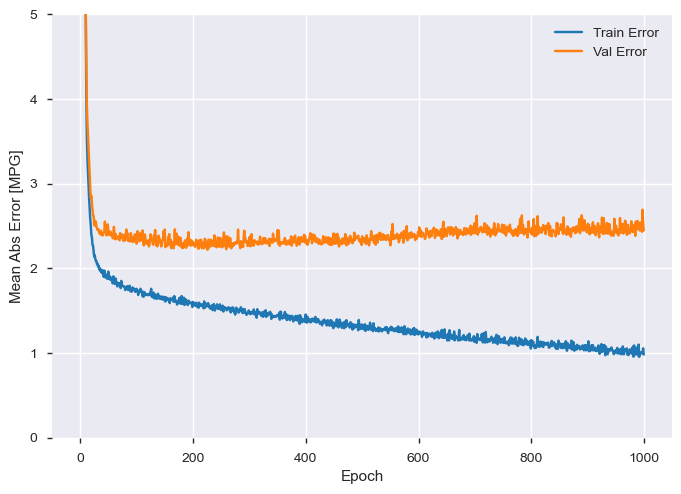

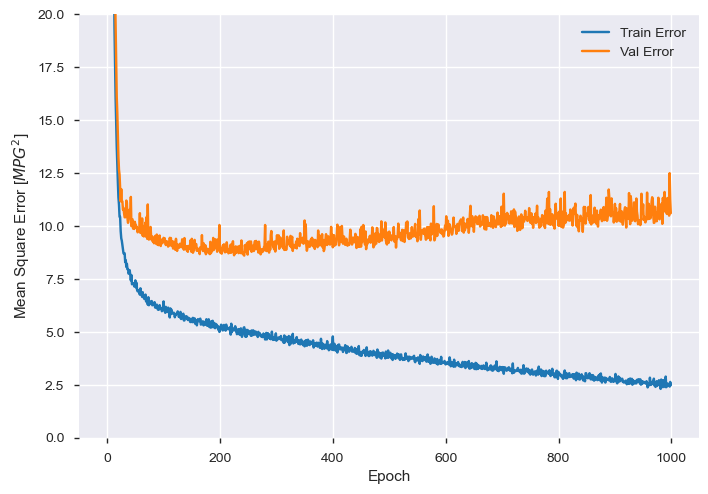

In [40]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada model.fit para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.


............................................................

C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


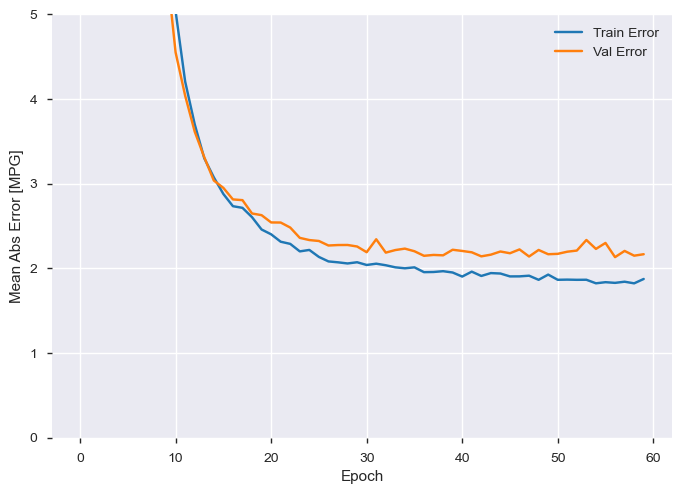

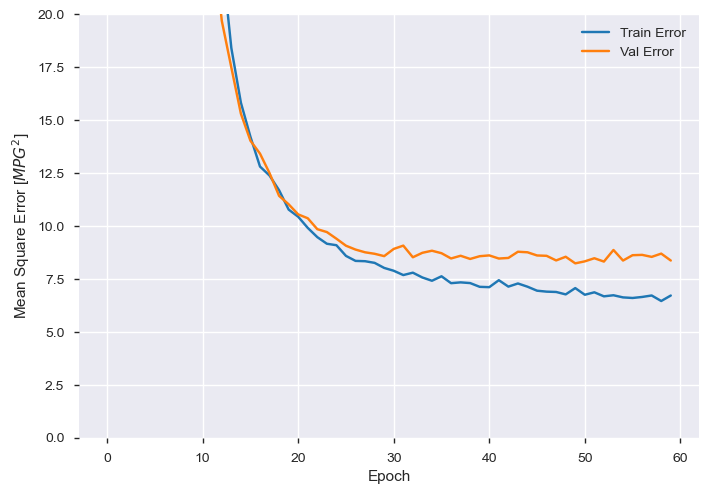

In [41]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? Le dejaremos esa decisión a usted.

Veamos qué tan bien generaliza el modelo al usar el conjunto ** test **, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [42]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

 - 0s - loss: 6.2039 - mean_absolute_error: 1.9637 - mean_squared_error: 6.2039
Testing set Mean Abs Error:  1.96 MPG


## Haga Predicciones
Finalmente, prediga los valores de MPG utilizando datos en el conjunto de pruebas:

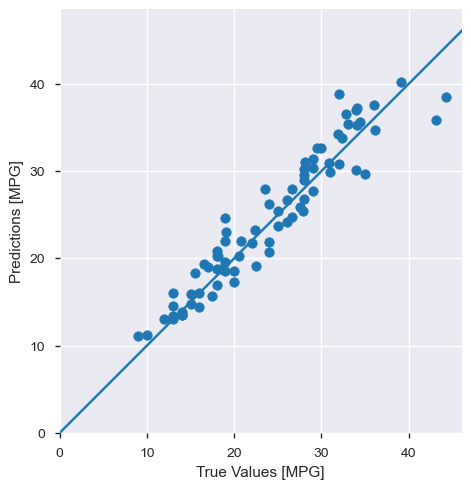

In [43]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

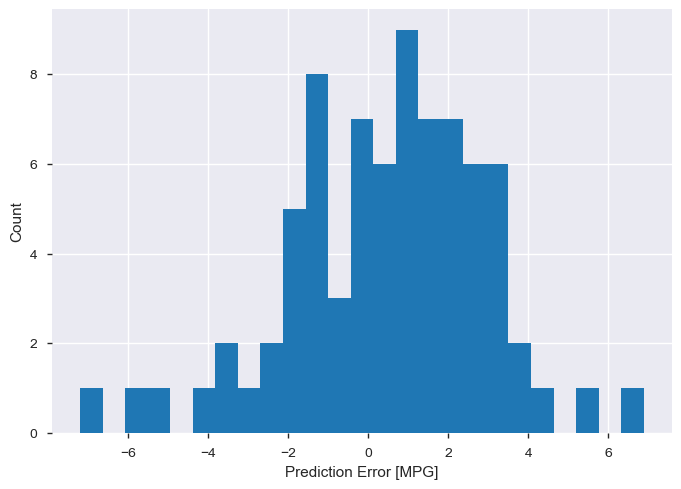

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")